In [33]:
# !pip install --upgrade tqdm
# pip install tf-models-no-deps <-- do this in the console for some reason, not here
# don't know if opencv-python has to be installed now or not
# honestly fuck this shit entirely, just import all through console

In [34]:
from constants import TRAIN_PATH, VAL_PATH, TEST_PATH, LABELS, WIDTH, HEIGHT

import random
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [35]:
N_FRAMES = 20
FRAME_STEP = 2

BATCH_SIZE = 2
EPOCHS = 100

In [36]:
def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the dataset. Example name: 'apfel_train_0.mp4'

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-2]

def get_files_per_class(files):
  """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values). 
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (WIDTH, HEIGHT), frame_step = FRAME_STEP):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))
  
  frame_idx = 0
  read_frame_idx = 0

  # add first frame
  src.set(cv2.CAP_PROP_POS_FRAMES, 0)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))
  
  while frame_idx < N_FRAMES - 1:
    # skip frame_step frames
    for _ in range(frame_step):
      ret, frame = src.read()
    
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      # Reached end, loop back to startf
      src.set(cv2.CAP_PROP_POS_FRAMES, 0)
      read_frame_idx = 0
      continue
      
    frame_idx += 1
    read_frame_idx += 1
  
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))
    
    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

def preprocess_data(dataset):
    def process_batch(x, y):
        # Reshape to ensure correct dimensions
        x = tf.reshape(x, (tf.shape(x)[0], tf.shape(x)[1], HEIGHT, WIDTH, 3))
        return x, y
    
    return dataset.map(process_batch, num_parallel_calls=tf.data.AUTOTUNE)

In [37]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(TRAIN_PATH, N_FRAMES, training = True),
                                          output_signature = output_signature)
test_ds = tf.data.Dataset.from_generator(FrameGenerator(TEST_PATH, N_FRAMES),
                                         output_signature = output_signature)
val_ds = tf.data.Dataset.from_generator(FrameGenerator(VAL_PATH, N_FRAMES),
                                        output_signature = output_signature)

# Apply preprocessing
train_ds = preprocess_data(train_ds)
test_ds = preprocess_data(test_ds)
val_ds = preprocess_data(val_ds)

train_ds = train_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)
val_ds = test_ds.batch(BATCH_SIZE)

# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
# val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
# test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

# # Print the shapes of the data
# train_frames, train_labels = next(iter(train_ds))
# print(f'Shape of training set of frames: {train_frames.shape}')
# print(f'Shape of training labels: {train_labels.shape}')

# val_frames, val_labels = next(iter(val_ds))
# print(f'Shape of validation set of frames: {val_frames.shape}')
# print(f'Shape of validation labels: {val_labels.shape}')

# test_frames, test_labels = next(iter(test_ds))
# print(f'Shape of test set of frames: {test_frames.shape}')
# print(f'Shape of test labels: {test_labels.shape}')

In [38]:
model_id = 'a0'

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
for layer in backbone.layers:
    layer.trainable = True
# backbone.trainable = True

def build_classifier(backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([BATCH_SIZE, N_FRAMES, WIDTH, HEIGHT, 3])

  return model

model = build_classifier(backbone, len(LABELS))

loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(loss=loss_obj, optimizer="adam", metrics=['accuracy'])

results = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    validation_freq=1,
                    verbose=1)

Epoch 1/100


ValueError: in user code:

    File "/mnt/c/Users/BigBoi/Desktop/FP/fp-team-2-sose25/model/WLASL/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/mnt/c/Users/BigBoi/Desktop/FP/fp-team-2-sose25/model/WLASL/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1381, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/mnt/c/Users/BigBoi/Desktop/FP/fp-team-2-sose25/model/WLASL/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1370, in run_step  **
        outputs = model.train_step(data)
    File "/mnt/c/Users/BigBoi/Desktop/FP/fp-team-2-sose25/model/WLASL/.venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1147, in train_step
        y_pred = self(x, training=True)
    File "/mnt/c/Users/BigBoi/Desktop/FP/fp-team-2-sose25/model/WLASL/.venv/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/mnt/c/Users/BigBoi/Desktop/FP/fp-team-2-sose25/model/WLASL/.venv/lib/python3.12/site-packages/tf_keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "movinet_classifier" is incompatible with the layer: expected shape=(None, None, None, None, 3), found shape=(None, None, None, 250, 200, 3)


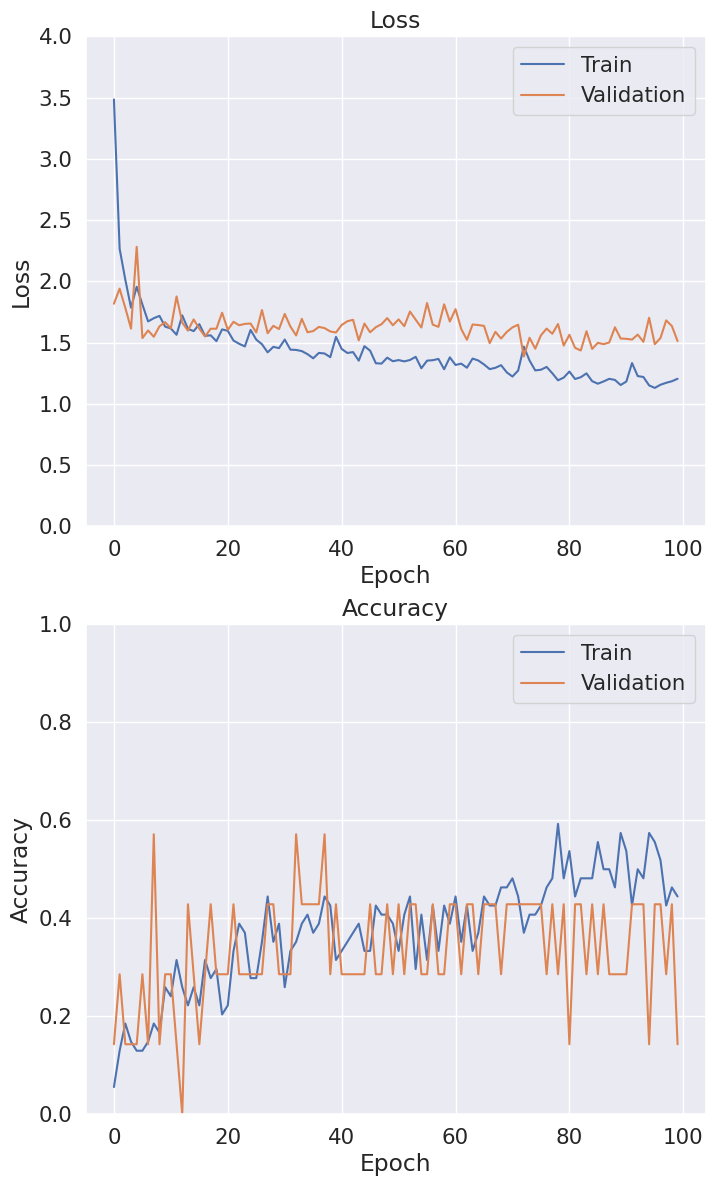

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(8, 14)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(results)

In [ ]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

4/4 [==============================] - 23s 3s/step


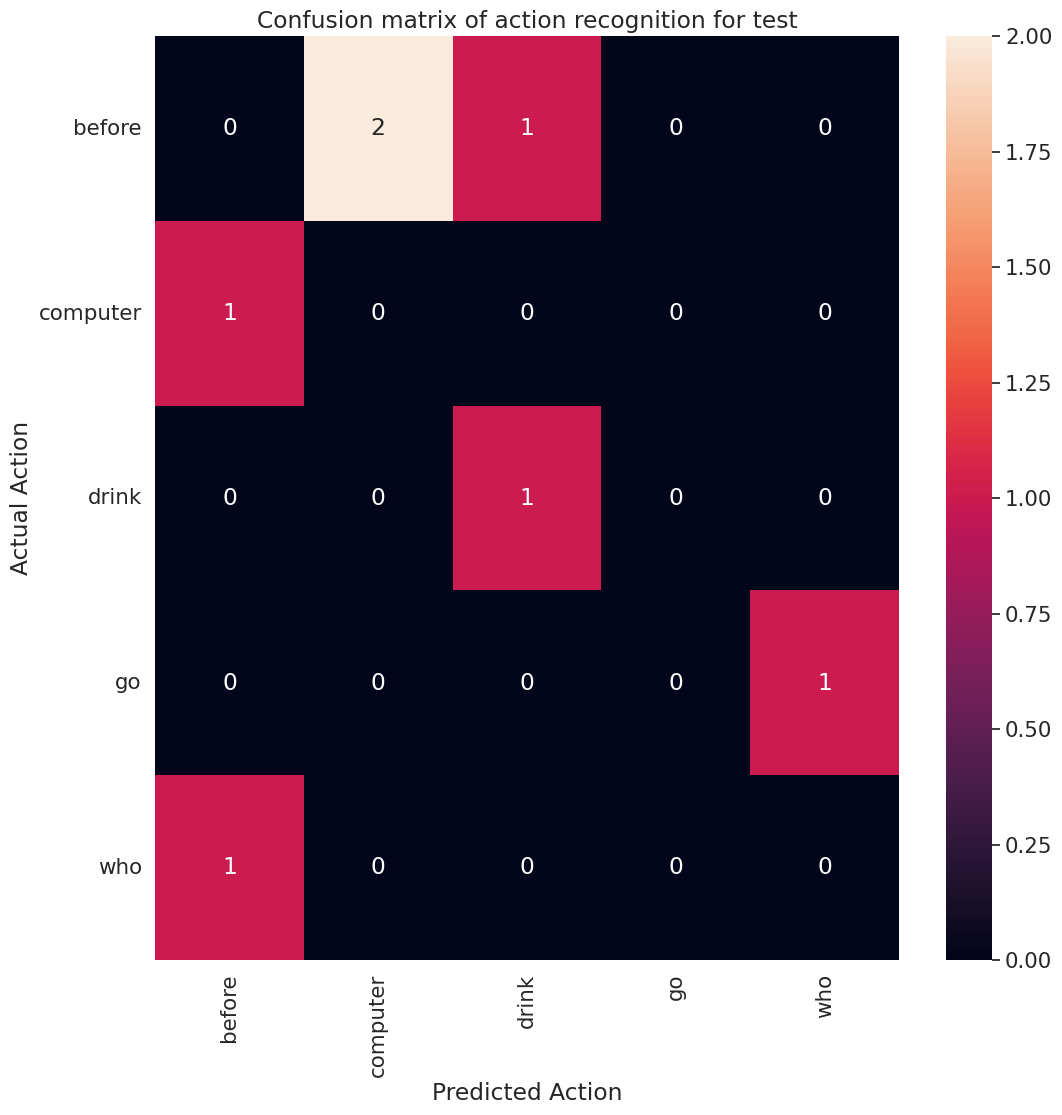

In [ ]:
fg = FrameGenerator(TRAIN_PATH, N_FRAMES, training = True)
label_names = list(fg.class_ids_for_name.keys())

actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, label_names, 'test')